In [1]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats

rng = np.random.default_rng()

In [2]:
def linlog_bins(data, numbins=10):
    """
    Logarithmic binning algorithm for discrete data. 
    Return bin edges that are linear in the range [1, logmin] 
    and logarithmic in the range [logmin, maxval + 1].
    logmin is chosen such that the widths of the logarithmic bins are
    at least 1.5.
    """
    maxval = np.max(data)
    for logmin in range(1, maxval):
        ratio = np.exp((np.log(maxval + 1) - np.log(logmin)) / (numbins - logmin + 2))
        if logmin * ratio > logmin + 1.5:
            break
    # Construct the bins
    bins = np.concatenate((np.arange(1, logmin), 
        np.ceil(np.geomspace(logmin, maxval + 1, numbins - logmin + 2)))) - 0.5
    return bins

# Implementing the random-walk based growing network model

The results of the previous section suggest that the friendship paradox is a general property of random networks. Can we leverage this property to design a growing network model that generates scale-free networks? Here, we implement the random-walk based growing network model. This model is based on the following idea:

1. Add a new node to the network and randomly select $m$ target nodes.
2. For each target node, select a random neighbor and move the target to that neighbor. 
3. Create a link between the new node and each of the $m$ target nodes after repeating step 2 for $t$ steps.
4. Repeat steps 1-3 until the network reaches the desired size $N$.

In [3]:
def rw_based_growing_network(N, m, t, seed_net_size, rng):
    '''
    Generate a growing network using the random walk based model.
    N: the final number of nodes in the network
    m: the number of edges to be added at each time step
    t: the length of the random walk
    seed_net_size: the size of the seed network
    rng: a numpy random number generator
    '''
    # Generate the seed network (a clique of size seed_net_size)
    G = nx.complete_graph(seed_net_size)    

    # TODO: Grow the network by adding nodes one by one until it reaches size N
    while len(G.nodes()) < N:
        # The index of the new node to be added
        new_node = max(G.nodes()) + 1
        nodes = list(G.nodes())
        G.add_node(new_node)

        # Choose m target nodes randomly from the existing nodes. 
        # For each target node, perform a random walk for t steps and add an edge
        # between the new node and the node reached by the random walk.
        # If the random walk reaches the new node itself or a node that is already connected to the new node, 
        # forming an edge would create a self-loop or a multi-edge, respectively.
        # In this case, restart the random walk from the target node.

        # YOUR CODE HERE
        targets = rng.choice(nodes, m, replace=False)
        for target in targets:
            for _ in range(t):
                if target == new_node or new_node in G.neighbors(target):
                    target = rng.choice(nodes)
                else:
                    break
            G.add_edge(new_node, target)
    return G

In [4]:
G = rw_based_growing_network(10000, m=3, t=8, seed_net_size=4, rng=rng)

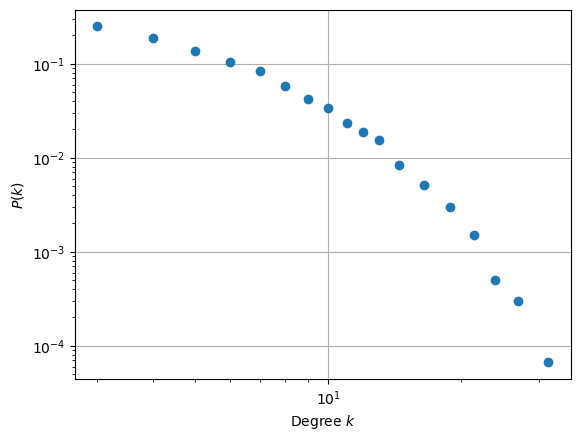

In [5]:
# Plot the degree distribution on a log-log scale
degrees = [degree for _, degree in G.degree()]
bins = linlog_bins(degrees, numbins=20)
pk, bin_edges = np.histogram(degrees, bins=bins, density=True)
bincenters, _, _ = scipy.stats.binned_statistic(degrees, degrees, statistic='mean', bins=bins)

fig, ax = plt.subplots()
ax.plot(bincenters, pk, 'o')
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel('Degree $k$')
ax.set_ylabel('$P(k)$')
ax.grid()

In [6]:
# Save the figure to current directory
figure_filename = 'rw_based_model_degree_distribution.pdf'
fig.savefig(figure_filename)